In [112]:
import os, sys
import glob
import json
import random
from collections import defaultdict
import cv2
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
sys.path.append(module_path)

module_path = os.path.abspath(os.path.join("../.."))
sys.path.append(module_path)

from dataset_utils.config import DS_ROOT, ROOT
from dataset_utils.utils import imshow_by_path, imshow_by_name
from dataset_utils.utils import get_image_paths, get_bb_and_landmarks_dict

from dataset_utils.Dataset import Dataset
from dataset_utils.utils import extract_eyes_region_from_aligned_face, gray, eqhist

from dataset_utils.DataInitiator import OmniDataInitiator

from train.utils.DataPathProvider import DataPathProvider

In [103]:
def display_score(pids, scores, title=None):
    assert len(pids) == len(scores)
    N = len(pids)
    width = 0.7
    x = np.arange(N)
    fig, ax = plt.subplots(figsize=(15, 5)) # Figureオブジェクトとそれに属する一つのAxesオブジェクトを同時に作成

    rects = ax.bar(x, scores, width, color='g')
    ax.set_xticks(x+width/2.)
    ax.set_xticklabels(pids)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xlabel("person id")
    ax.set_ylabel("fscore")
    ax.set_title(title)

    def attach_scores(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*height, '%.2f' % height,
                    ha='center', va='bottom')

    attach_scores(rects)
    plt.show()

# 顔画像検出の精度分析
idが5の倍数のface_direction_featureをみればいい

In [106]:
dic = get_bb_and_landmarks_dict()

In [107]:
dsdir = os.path.join(DS_ROOT, "image")
img_paths = glob.glob(os.path.join(dsdir, "*", "*.jpg"))
data_initiator = OmniDataInitiator()
data  = [data_initiator.init(os.path.basename(path)) for path in img_paths]
data = [d for d in data if d.id % 5 == 0]

pid2count = defaultdict(lambda: {True: [], False: []})

for d in data:
    spid = "%04d" % d.pid
    if d.name not in dic[spid] or 'bb' not in dic[spid][d.name]:
        pid2count[d.pid][False].append(d.name)
    else:
        pid2count[d.pid][True].append(d.name)

In [108]:
pids = []
accuracy = []
for pid in sorted(pid2count.keys()):
    success = len(pid2count[pid][True])
    failed = len(pid2count[pid][False])
    pids.append(pid)
    accuracy.append(float(success)/(success+failed))
    print("pid: %d, 成功: %d, 失敗: %d, 精度: %.3f" % (pid, success, failed, float(success)/(success+failed)))
    
tmp  = [(len(count[True]), len(count[False])) for pid, count in pid2count.items()]
success = sum(e[0] for e in tmp)
failed = sum(e[1] for e in tmp)
print("成功: %d, 失敗: %d, 精度: %.3f" % (success, failed, float(success)/(success+failed)))

pid: 1, 成功: 132, 失敗: 43, 精度: 0.754
pid: 2, 成功: 1276, 失敗: 440, 精度: 0.744
pid: 3, 成功: 639, 失敗: 343, 精度: 0.651
pid: 4, 成功: 1223, 失敗: 257, 精度: 0.826
pid: 5, 成功: 786, 失敗: 348, 精度: 0.693
pid: 6, 成功: 726, 失敗: 183, 精度: 0.799
pid: 7, 成功: 1098, 失敗: 180, 精度: 0.859
pid: 8, 成功: 730, 失敗: 127, 精度: 0.852
pid: 9, 成功: 893, 失敗: 220, 精度: 0.802
pid: 10, 成功: 480, 失敗: 436, 精度: 0.524
pid: 11, 成功: 966, 失敗: 202, 精度: 0.827
pid: 12, 成功: 1529, 失敗: 385, 精度: 0.799
pid: 13, 成功: 1092, 失敗: 288, 精度: 0.791
pid: 14, 成功: 870, 失敗: 304, 精度: 0.741
pid: 15, 成功: 977, 失敗: 187, 精度: 0.839
pid: 16, 成功: 732, 失敗: 319, 精度: 0.696
pid: 17, 成功: 795, 失敗: 244, 精度: 0.765
成功: 14944, 失敗: 4506, 精度: 0.768


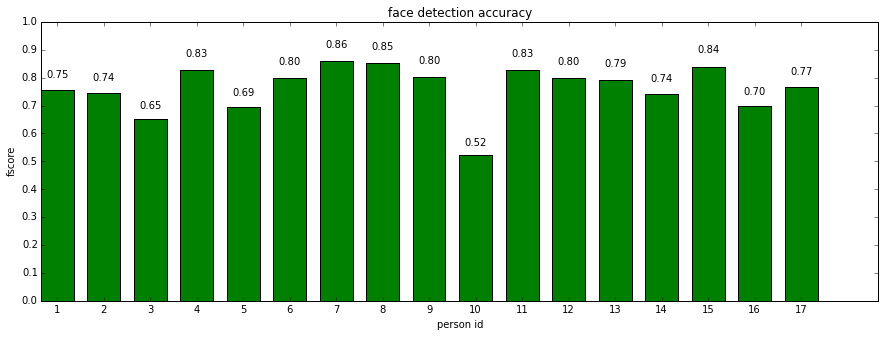

In [114]:
display_score(pids, accuracy, "face detection accuracy")

# エラー検出されたデータ数の分析

### pidごとのデータ数

In [86]:
dsdir = os.path.join(DS_ROOT, "face")
img_paths = glob.glob(os.path.join(dsdir, "*", "*.jpg"))
data_initiator = OmniDataInitiator()
data  = [data_initiator.init(os.path.basename(path)) for path in img_paths]
data = [d for d in data if d.id % 5 == 0]

pid2count = defaultdict(int)
for d in data:
    pid2count[d.pid] += 1

In [99]:
error_path = os.path.join(DS_ROOT, "predicted_noise_each_eye.json")
with open(error_path, "r") as fr:
    errors = json.load(fr)
data_initiator = OmniDataInitiator()
error_data = [data_initiator.init(fname) for fname in errors.keys()]
pid2error = defaultdict(int)
for d in error_data:
    pid2error[d.pid] += 1

In [102]:
for pid in sorted(pid2count.keys()):
    print("pid: %d, 検出数: %d, データ数: %d, 検出割合: %.3f" % (pid, pid2error[pid], pid2count[pid], float(pid2error[pid])/pid2count[pid]))
print("検出合計: %d, データ合計: %d, 検出割合: %.3f" % (sum(pid2error.values()), sum(pid2count.values()), float(sum(pid2error.values()))/sum(pid2count.values())))

pid: 1, 検出数: 92, データ数: 132, 検出割合: 0.697
pid: 2, 検出数: 330, データ数: 1276, 検出割合: 0.259
pid: 3, 検出数: 143, データ数: 639, 検出割合: 0.224
pid: 4, 検出数: 575, データ数: 1223, 検出割合: 0.470
pid: 5, 検出数: 104, データ数: 967, 検出割合: 0.108
pid: 6, 検出数: 177, データ数: 726, 検出割合: 0.244
pid: 7, 検出数: 164, データ数: 1098, 検出割合: 0.149
pid: 8, 検出数: 118, データ数: 730, 検出割合: 0.162
pid: 9, 検出数: 146, データ数: 893, 検出割合: 0.163
pid: 10, 検出数: 296, データ数: 480, 検出割合: 0.617
pid: 11, 検出数: 402, データ数: 966, 検出割合: 0.416
pid: 12, 検出数: 306, データ数: 1529, 検出割合: 0.200
pid: 13, 検出数: 100, データ数: 1092, 検出割合: 0.092
pid: 14, 検出数: 291, データ数: 870, 検出割合: 0.334
pid: 15, 検出数: 136, データ数: 977, 検出割合: 0.139
pid: 16, 検出数: 364, データ数: 732, 検出割合: 0.497
pid: 17, 検出数: 181, データ数: 795, 検出割合: 0.228
検出合計: 3925, データ合計: 15125, 検出割合: 0.260


In [11]:
conf_id = "decrease_noise"
conf_path = os.path.join(ROOT, "train", "init.json")

def load_conf(conf_fpath, conf_id, conf=None):
    assert os.path.exists(conf_fpath)
    
    if conf is None:
        conf = defaultdict(lambda: None)
        
    with open(conf_fpath, 'r') as fr:
        conf_raw = json.load(fr)[conf_id]
    
    for key in conf_raw.keys():
        conf[key] = conf_raw[key]
    
    return conf

def report_conf(conf):
    print(' '.join(['-' * 25, 'conf', '-' * 25]))
    for key, value in sorted(conf.items()):
        print('%s => %s' % (key, value))

conf_def = load_conf(conf_path, 'default')
conf = load_conf(conf_path, conf_id, conf=conf_def)
conf['conf_id'] = conf_id
report_conf(conf)

face_dir_dict = None
if conf['face_direction_dir']:
    face_dir_dict = {}
    dir_path = conf['face_direction_dir']
    json_fnames = [fname for fname in os.listdir(dir_path) if 'json' in fname]
    for json_fname in json_fnames:
        path = os.path.join(dir_path, json_fname)
        with open(path, 'r') as fr:
            d = json.load(fr)
            for k, v in d.items():
                face_dir_dict[k] = v
    
path_provider = DataPathProvider(conf)


------------------------- conf -------------------------
annotation_path => False
batch_size => 64
blink_noise_path => ../data/omni/blink.json
block_size => 512
bulking => True
conf_id => decrease_noise
data_initiator => OmniDataInitiator
dataset_path => ../data/omni/both_eyes_from_aligned_face2
epoch => 10
face_direction_path => False
glasses => False
group_num => 17
ignored_targets => [3, 4, 5, 6]
img_format => jpg
img_size => [32, 96]
learn_rate => 0.01
locked_targets => [0, 1, 2, 31, 32, 50]
model_path => ./trained
noise_data_paths => [u'../data/omni/noise_data.json', u'../data/omni/predicted_noise_each_eye.json', u'../data/omni/invalid.json']
nonlocked_rate => False
pids => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
places => [u'A', u'B', u'C', u'D']
result_path => ./result
skip_num => 4
pid 1-> 13
pid 2-> 713
pid 3-> 382
pid 4-> 489
pid 5-> 268
pid 6-> 434
pid 7-> 357
pid 8-> 241
pid 9-> 239
pid 10-> 126
pid 11-> 446
pid 12-> 489
pid 13-> 335
pid 14-> 463
pid 15-

In [13]:
print(len(path_provider.dataset.data))

5781


In [ ]:
path_provider.save_datset("./dataset_summer1.pkl")